# Bollinger Bands Strategy and Backtesting Report

******************************************************
**Prepared By : Samalie Piwan**  
**Andrew ID: spiwan**  
**Semester: Fall 2023**  
**Last modified: 2nd October 2023**  
******************************************************

## Strategy Backtesting Implementation

In [141]:
#Load the libraries to be used in the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

def backtest_strategy(symbol, data_file, date_col, pricing_col, window):
    
    """
    This function backtests a symbol using the bollinger bands strategy to evaluate the strategy's performance
    
    Attributes
    -----------
        symbol : str
            The name of the symbol to be displayed in the graph title
        data_file: str
            The file to load the pricing data from
        date_col: str
            The name of the column to be used as the date in the file loaded
        pricing_col : str
            The name of the column that contains the pricing data
        window:
            The number of days to use when computing the Simple Moving Average
            
    Return
    -----------
        None
    
    """
    
    #Load the libraries to be used in the project
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

    #Load the data from the downloaded file
    parent_df = pd.read_csv(data_file).dropna()
    
    main_df = parent_df[[date_col,pricing_col]].copy()

    #Convert the date column to datetime
    main_df[date_col] = pd.to_datetime(main_df[date_col])
    #Set the Date column as the index
    main_df_indexed = main_df.set_index(date_col)

    #Get the SMA value
    sma = main_df_indexed[pricing_col].rolling(window).mean()

    #Calculate the SMA for the simple_moving_average on the dataframe
    main_df_indexed['SMA'] = sma

    #Get the standard deviation of the pricing column
    standard_deviation =  main_df_indexed[pricing_col].rolling(window).std()

    main_df_indexed['Upper Band'] =  sma + standard_deviation * 2
    main_df_indexed['Lower Band'] = sma - standard_deviation * 2
    
    #Plot the figures with the bollinger bands
    #plt.figure(figsize=(12,6))
    #plt.title(symbol+" Bollinger Bands")
    #main_df_indexed[pricing_col].plot(label = 'PRICES', color = 'skyblue')
    #main_df_indexed['Upper Band'].plot(label = 'UPPER BAND '+str(window), linestyle = '--', linewidth = 1, color = 'black')
    #main_df_indexed['SMA'].plot(label = 'MIDDLE BAND '+str(window), linestyle = '--', linewidth = 1.2, color = 'grey')
    #main_df_indexed['Lower Band'].plot(label = 'LOWER BAND '+str(window), linestyle = '--', linewidth = 1, color = 'black')
    #plt.legend(loc='upper left')
    #plt.grid()
    #plt.show()

    # Generate the trading signals
    buy_price = []
    sell_price = []
    bands_signal = []
    signal = 0

    for i in range(len(main_df_indexed[pricing_col])):
        if(main_df_indexed[pricing_col][i-1] > main_df_indexed['Lower Band'][i-1] and main_df_indexed[pricing_col][i] < main_df_indexed['Lower Band'][i]):
            if(signal != 1):
                buy_price.append(main_df_indexed[pricing_col][i])
                sell_price.append(np.nan)
                signal = 1
                bands_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bands_signal.append(0)
        elif(main_df_indexed[pricing_col][i-1] < main_df_indexed['Upper Band'][i-1] and main_df_indexed[pricing_col][i] > main_df_indexed['Upper Band'][i]):
            if(signal != -1):
                buy_price.append(np.nan)
                sell_price.append(main_df_indexed[pricing_col][i])
                signal = -1
                bands_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bands_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bands_signal.append(0)

    #Create positions for our strategy
    position = []
    for i in range(len(bands_signal)):
        if bands_signal[i] > 1:
            position.append(0)
        else:
            position.append(1)

    for i in range(len(main_df_indexed[pricing_col])):
        if bands_signal[i] == 1:
            position[i] = 1
        elif bands_signal[i] == -1:
            position[i] = 0
        else:
            position[i] = position[i-1]

    #Create a copy of the main dataset
    main_df_new = main_df_indexed.copy()

    #Add the bands_signal list to the main dataset
    main_df_new['Band Signals'] = bands_signal

    #Add the positions list to the main dataset
    main_df_new['Band Position'] = position

    #Calculate the returns on the data
    main_df_new['Returns'] = np.log(main_df_new[pricing_col] / main_df_new[pricing_col].shift(1))

    #Calculate the performance on the strategy data
    main_df_new['Strategy'] = main_df_new['Band Position'].shift(1) * main_df_new['Returns']
    
    #Compute the cummulative returns from the returns dataset
    main_df_new['Cummulative Strategy'] = main_df_new['Strategy'].cumsum().apply(np.exp)
    main_df_new['Cummulative Returns'] = main_df_new['Returns'].cumsum().apply(np.exp)

    #Plot the figures with the trading signals
    plt.figure(figsize = (12,6))
    plt.title(symbol+" Equity Lines - 01/01/2020 TO 31/12/2021")
    plt.plot(main_df_new['Cummulative Strategy'], label = "Strategy")
    plt.plot(main_df_new['Cummulative Returns'], label = "Returns")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend(loc='upper left')
    plt.show()

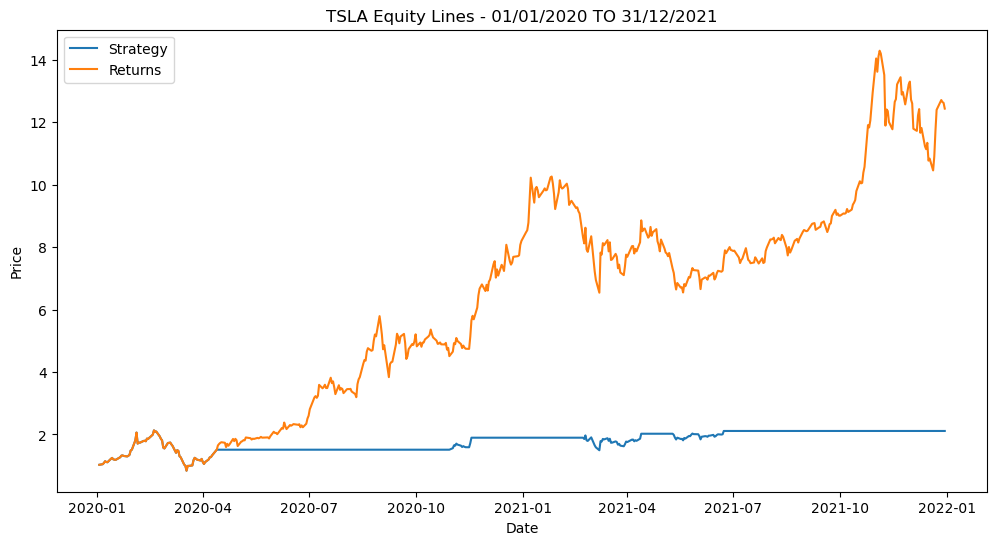

In [142]:
backtest_strategy('TSLA', 'tsla.csv', 'Date', 'Adj Close', 20)

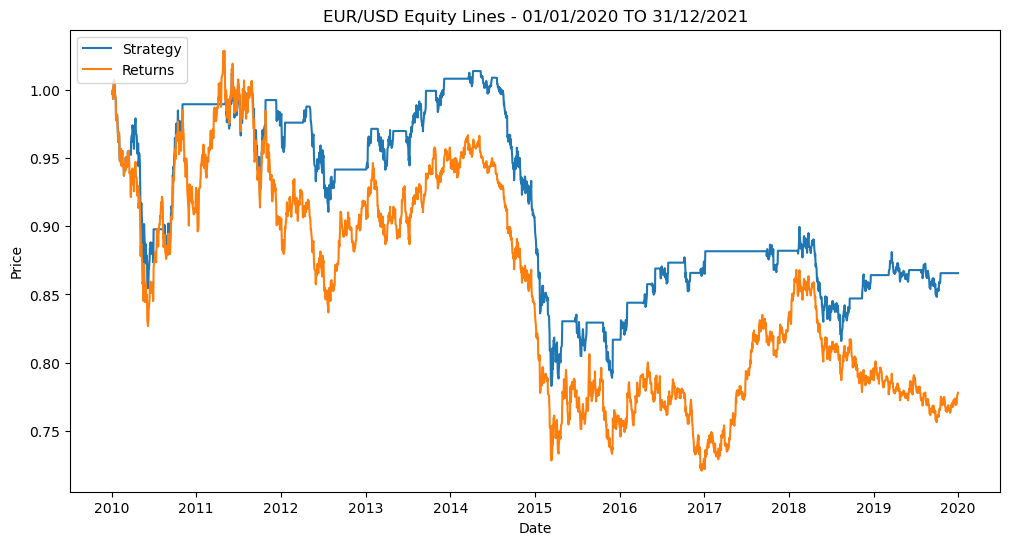

In [143]:
backtest_strategy('EUR/USD', 'pyalgo_eikon_eod_data.csv', 'Date', 'EUR=', 10)